<a href="https://colab.research.google.com/github/Heity94/TWSM_Lab/blob/main/Homework/7_Class_Homework/HW_7_PH_Fine_tuning_a_model_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning a model with Keras

Install the Transformers and Datasets libraries to run this notebook.

In [ ]:
!pip install folium==0.2.1

In [ ]:
!pip install datasets transformers[sentencepiece]

Load raw dataset from drive

In [40]:
# Imports
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import numpy as np

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [98]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/02_HWR/00_data/QQP"

In [104]:
# Load raw datasets from path, split into train and validation
raw_datasets = load_dataset(data_path, data_files={'train': data_path+'/train.tsv', 'validation': data_path+'/dev.tsv'})

Using custom data configuration QQP-6731c069838b721c
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/QQP-6731c069838b721c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

In [105]:
# Number of rows in raw dataset
print("number of rows in train set:", raw_datasets['train'].num_rows)
print("number of rows in val set:", raw_datasets['validation'].num_rows)

number of rows in train set: 363846
number of rows in val set: 40430


Downsample the train & validation dataset

In [109]:
# Considering only 1/10th of the original images
reduction_factor = 10

# Choosing the random indices of small train set and small test set
idx_train =  np.random.choice(raw_datasets['train'].num_rows, round(raw_datasets['train'].num_rows/reduction_factor))
idx_val =  np.random.choice(raw_datasets['validation'].num_rows, round(raw_datasets['validation'].num_rows/reduction_factor))

In [110]:
# Collecting the two subsamples 
raw_datasets_train_small = raw_datasets["train"][idx_train]
raw_datasets_validation_small = raw_datasets["validation"][idx_val]

In [112]:
# Convert back to Dataset object
from datasets import Dataset
raw_datasets_train_small = Dataset.from_dict(raw_datasets_train_small)
raw_datasets_validation_small = Dataset.from_dict(raw_datasets_validation_small)

In [116]:
print("------------------ Before -----------------")
print(raw_datasets['train'].num_rows, raw_datasets['validation'].num_rows)

print("")

print("--- After applying the reduction factor ---")
print(raw_datasets_train_small.num_rows, raw_datasets_validation_small.num_rows)

print("")
print("--- Distribution of target labels in small train subsample ---")

unique, counts = np.unique(raw_datasets_train_small["is_duplicate"], return_counts=True)
dict(zip(unique, counts))

------------------ Before -----------------
363846 40430

--- After applying the reduction factor ---
36385 4043

--- Distribution of target labels in small train subsample ---


{0: 23028, 1: 13357}

In [54]:
#Instantiate tokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [55]:
# Create tokenizer function
def tokenize_function(example):
    return tokenizer(example["question1"], example["question2"], truncation=True)

In [118]:
# Tokenize dataset
tokenized_dataset_train_small = raw_datasets_train_small.map(tokenize_function, batched=True)
tokenized_dataset_val_small = raw_datasets_validation_small.map(tokenize_function, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [119]:
# Collator with padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [120]:
tf_train_dataset = tokenized_dataset_train_small.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["is_duplicate"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_dataset_val_small.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["is_duplicate"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [121]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [122]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 8
num_epochs = 3
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [123]:
import tensorflow as tf

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [124]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3)

Epoch 1/3
4548/4548 [==============================] - 581s 125ms/step - loss: 0.4060 - accuracy: 0.8042 - val_loss: 0.3314 - val_accuracy: 0.8486
Epoch 2/3
4548/4548 [==============================] - 566s 124ms/step - loss: 0.2229 - accuracy: 0.9085 - val_loss: 0.3300 - val_accuracy: 0.8598
Epoch 3/3
4548/4548 [==============================] - 578s 127ms/step - loss: 0.0835 - accuracy: 0.9710 - val_loss: 0.4770 - val_accuracy: 0.8583


In [125]:
preds = model.predict(tf_validation_dataset)["logits"]

In [126]:
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

(4043, 2) (4043,)


Look into the available metrics for such a task. Can you create confusion matrices and ROC curves 

In [127]:
# List all available metrics
from datasets import list_metrics, load_metric
metrics_list = list_metrics()
len(metrics_list)
print(metrics_list)

['accuracy', 'bertscore', 'bleu', 'bleurt', 'cer', 'chrf', 'code_eval', 'comet', 'competition_math', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'pearsonr', 'perplexity', 'precision', 'recall', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'wer', 'wiki_split', 'xnli', 'xtreme_s']


In [158]:
# Load metrics of interest
metrics = ["accuracy", "precision", "recall", "f1"]

In [160]:
results = []

for metric in metrics:
  met_tmp = load_metric(metric)
  res_tmp = met_tmp.compute(predictions=class_preds, references=tokenized_dataset_val_small["is_duplicate"])
  results.append(res_tmp)

In [161]:
results

[{'accuracy': 0.8582735592381895},
 {'precision': 0.7905897945659377},
 {'recall': 0.8227586206896552},
 {'f1': 0.806353497803312}]

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, RocCurveDisplay

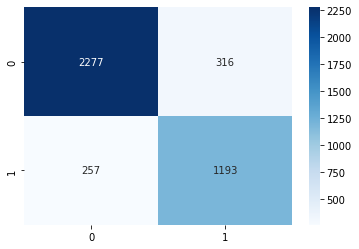

In [195]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(tokenized_dataset_val_small["is_duplicate"], class_preds), cmap='Blues', fmt='g', annot=True);

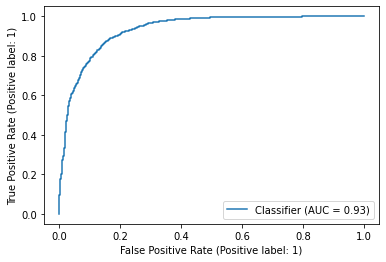

In [208]:
# Plot ROC curve
RocCurveDisplay.from_predictions(tokenized_dataset_val_small["is_duplicate"], preds[:,1]);